In order to run the code more conveniently, the follwing case uses the model provided by *sklearn*, and the detailed composition of some algorithms please refer to `Algorithms` folder.

In [43]:
import pickle
import pandas as pd
import numpy as np
import sklearn
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

# Data Preprocess

In [44]:
# read data
def readData(dataType):
    if dataType == 'raw':
        # read row data
        train = pd.read_pickle('tweets-data/train.pkl')
        test = pd.read_pickle('tweets-data/test.pkl')
        dev = pd.read_pickle('tweets-data/dev.pkl')
        unlabeled = pd.read_pickle('tweets-data/unlabeled.pkl')
    elif dataType == 'tfidf':
        # read TFIDF data
        train = pd.read_pickle('tfidf/train_tfidf.pkl')
        test = pd.read_pickle('tfidf/test_tfidf.pkl')
        dev = pd.read_pickle('tfidf/dev_tfidf.pkl')
        unlabeled = pd.read_pickle('tfidf/unlabeled_tfidf.pkl')
    elif dataType == 'embeding':
        # read embeding data
        train = pd.read_pickle('sentence-transformers/train_emb.pkl')
        test = pd.read_pickle('sentence-transformers/test_emb.pkl')
        dev = pd.read_pickle('sentence-transformers/dev_emb.pkl')
        unlabeled = pd.read_pickle('sentence-transformers/unlabeled_emb.pkl')
    else:
        print("Error: Wrong data type value")
    
    return (train, dev, test, unlabeled)

# data preprocess
def preprocess(data):
    train, dev, test, unlabeled = data
    train['Sentiment'] = pd.Categorical(train['Sentiment'])
    train['Sentiment'] = train.Sentiment.cat.codes

    unlabeled['Sentiment'] = pd.Categorical(unlabeled['Sentiment'])
    unlabeled['Sentiment'] = unlabeled.Sentiment.cat.codes

    dev['Sentiment'] = pd.Categorical(dev['Sentiment'])
    dev['Sentiment'] = dev.Sentiment.cat.codes
    
    return (train, dev, test, unlabeled)

In [45]:
# dataType = ['raw', 'tfidf', 'embeding']
tfidf_data = readData('tfidf')
tfidf_data = preprocess(tfidf_data)

embed_data = readData('embeding')
embed_data = preprocess(embed_data)

# Baseline Model

In [46]:
from sklearn.dummy import DummyClassifier

def BaselineModel(data):
    train, dev, test, unlabeled = data

    X_train, y_train = train['TFIDF'][:].tolist(), train['Sentiment']
    X_test, y_test = dev['TFIDF'][:].tolist(), dev['Sentiment']

    clf = DummyClassifier(strategy="most_frequent")
    baseline = clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)
    
    return (accuracy, precision, recall, f1, cm)

# Supervised

### 1. K-Nearest Neighbors

In [47]:
from sklearn.neighbors import KNeighborsClassifier

def KNN(data, k=3):
    train, dev, test, unlabeled = data

    X_train, y_train = train['TFIDF'][:].tolist(), train['Sentiment']
    X_test, y_test = dev['TFIDF'][:].tolist(), dev['Sentiment']

    clf = KNeighborsClassifier(n_neighbors=k)
    knn = clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)
    
    return (accuracy, precision, recall, f1, cm)

### 2. Gaussian Naive Bayes

In [48]:
from sklearn.naive_bayes import GaussianNB

def GNB(data):
    train, dev, test, unlabeled = data
    
    X_train, y_train = train['TFIDF'][:].tolist(), train['Sentiment']
    X_test, y_test = dev['TFIDF'][:].tolist(), dev['Sentiment']
    
    clf = GaussianNB()
    gnb = clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)
    
    return (accuracy, precision, recall, f1, cm)

# Unsupervised

### 1. K-Means

In [49]:
from sklearn.cluster import KMeans

def K_Means(data):
    train, dev, test, unlabeled = data
    
    X_train = unlabeled['TFIDF'][:].tolist()
    X_test, y_test = dev['TFIDF'][:].tolist(), dev['Sentiment']
    
    clf = KMeans(n_clusters=2, random_state=0)
    k_means = clf.fit(X_train)
    
    y_pred = clf.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)
    
    return (accuracy, precision, recall, f1, cm)

# Semi-supervised

### 1. Self-Training GNB

In [50]:
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.naive_bayes import GaussianNB

def SelfTrain_GNB(data, rng=100000):
    train, dev, test, unlabeled = data
    
    df = pd.concat([train, unlabeled[:rng]])
    df = df.sample(frac=1).reset_index(drop=True)

    X_train, y_train = df['TFIDF'][:].tolist(), df['Sentiment']
    X_test, y_test = dev['TFIDF'][:].tolist(), dev['Sentiment']
    
    GNB = GaussianNB()
    clf = SelfTrainingClassifier(GNB)
    
    self_training_model = clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)
    
    return (accuracy, precision, recall, f1, cm)

### 2. Self-Training K-NN

In [51]:
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.neighbors import KNeighborsClassifier

def SelfTrain_KNN(data, rng=100000, k=35):
    train, dev, test, unlabeled = data
    
    df = pd.concat([train, unlabeled[:rng]])
    df = df.sample(frac=1).reset_index(drop=True)
    
    X_train, y_train = df['TFIDF'][:].tolist(), df['Sentiment']
    X_test, y_test = dev['TFIDF'][:].tolist(), dev['Sentiment']
    
    knn = KNeighborsClassifier(n_neighbors=k)
    
    clf = SelfTrainingClassifier(knn)
    
    self_training_model = clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)
    
    return (accuracy, precision, recall, f1, cm)

# Model analysis

### Find the best k for K-NN

100%|██████████| 50/50 [07:40<00:00,  9.21s/it]


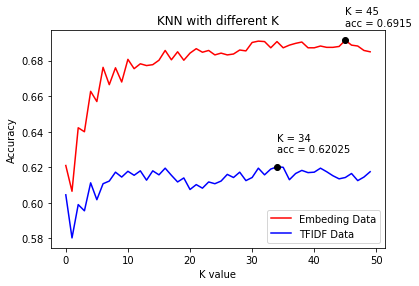

In [13]:
knn_embed_record = []
knn_tfidf_record = []

for i in tqdm(range(50)):
    knn_embed_record.append(KNN(embed_data, k=i+1)[0])
    knn_tfidf_record.append(KNN(tfidf_data, k=i+1)[0])

knn_x = np.array([i for i in range(len(knn_embed_record))])

argmax_embed = np.argmax(knn_embed_record)
max_embed = max(knn_embed_record)

argmax_tfidf = np.argmax(knn_tfidf_record)
max_tfidf = max(knn_tfidf_record)

plt.plot(knn_x, np.array(knn_embed_record), color='r', label='Embeding Data')
plt.plot(knn_x, np.array(knn_tfidf_record), color='b', label='TFIDF Data')

plt.plot(argmax_embed,max_embed,'ko')
plt.plot(argmax_tfidf,max_tfidf,'ko')

max_embed_text = "K = " + str(argmax_embed) + "\n" + "acc = " + str(max_embed)
max_tfidf_text = "K = " + str(argmax_tfidf) + "\n" + "acc = " + str(max_tfidf)

plt.annotate(max_embed_text, xy=(argmax_embed, max_embed),xytext=(argmax_embed, max_embed+0.008))
plt.annotate(max_tfidf_text, xy=(argmax_tfidf, max_tfidf),xytext=(argmax_tfidf, max_tfidf+0.008))

plt.title("KNN with different K")
plt.xlabel("K value")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Analysis

In [52]:
#data type: embeding
e_Baseline_score = BaselineModel(embed_data)

e_KNN_score = KNN(embed_data, k=45)
e_GNB_score = GNB(embed_data)

e_K_Means_score = K_Means(embed_data)

e_SelfTrain_GNB_score = SelfTrain_GNB(embed_data)
e_SelfTrain_KNN_score = SelfTrain_KNN(embed_data)


# data type: tfidf
t_Baseline_score = BaselineModel(tfidf_data)

t_KNN_score = KNN(tfidf_data, k=34)
t_GNB_score = GNB(tfidf_data)

t_K_Means_score = K_Means(tfidf_data)

t_SelfTrain_GNB_score = SelfTrain_GNB(tfidf_data)
t_SelfTrain_KNN_score = SelfTrain_KNN(tfidf_data)

/Users/macbookpro/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/macbookpro/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


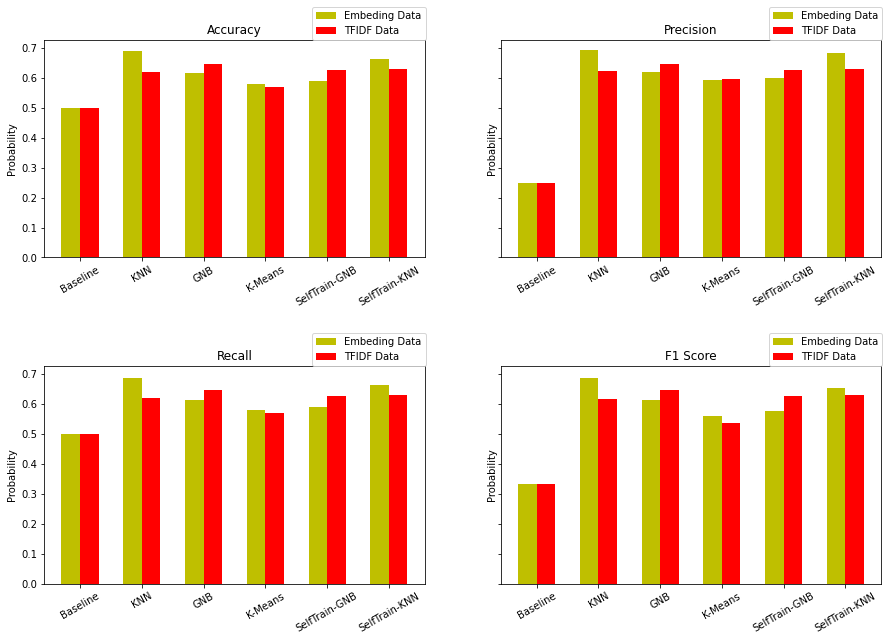

In [53]:
#data type: embeding
score = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
models = ['Baseline','KNN', 'GNB', 'K-Means', 'SelfTrain-GNB', 'SelfTrain-KNN']
models_index = {'Baseline':0,'KNN':1, 'GNB':2, 'K-Means':3, 'SelfTrain-GNB':4, 'SelfTrain-KNN':5}

# score = ['accuracy', 'precision', 'recall', 'f1']
e_data = [e_Baseline_score, e_KNN_score, e_GNB_score, e_K_Means_score, e_SelfTrain_GNB_score, e_SelfTrain_KNN_score]

e_accuracy_list = [0 for _ in range(len(models))]
e_precision_list = [0 for _ in range(len(models))]
e_recall_list = [0 for _ in range(len(models))]
e_f1_list = [0 for _ in range(len(models))]

for i in range(len(e_data)):
    e_accuracy_list[i] = e_data[i][0]
    e_precision_list[i] = e_data[i][1]
    e_recall_list[i] = e_data[i][2]
    e_f1_list[i] = e_data[i][3]
    
e_data_list = [e_accuracy_list, e_precision_list, e_recall_list, e_f1_list]
    
#data type: tfidf
t_data = [t_Baseline_score, t_KNN_score, t_GNB_score, t_K_Means_score, t_SelfTrain_GNB_score, t_SelfTrain_KNN_score]

t_accuracy_list = [0 for _ in range(len(models))]
t_precision_list = [0 for _ in range(len(models))]
t_recall_list = [0 for _ in range(len(models))]
t_f1_list = [0 for _ in range(len(models))]

for i in range(len(t_data)):
    t_accuracy_list[i] = t_data[i][0]
    t_precision_list[i] = t_data[i][1]
    t_recall_list[i] = t_data[i][2]
    t_f1_list[i] = t_data[i][3]

t_data_list = [t_accuracy_list, t_precision_list, t_recall_list, t_f1_list]

bar_width = 0.3
index_e_data = np.arange(len(models))
index_t_data = index_e_data + bar_width

fig, axs = plt.subplots(2, 2, figsize=(15, 10), sharey=True)

index_count = 0

for i in range(2):
    for j in range(2):
        axs[i][j].bar(index_e_data, height=e_data_list[index_count], width=bar_width, color='y', label='Embeding Data')
        axs[i][j].bar(index_t_data, height=t_data_list[index_count], width=bar_width, color='r', label='TFIDF Data')

        axs[i][j].legend(loc=(0.705,1))
        axs[i][j].set_title(score[index_count])
        axs[i][j].set_xticks(index_e_data+(0.5*bar_width))
        axs[i][j].set_xticklabels(models, rotation=30)
        axs[i][j].set_ylabel('Probability')
        index_count += 1

plt.subplots_adjust(hspace=0.5)
plt.show()

In [54]:
print("------------------------Sentence-transformers dataset------------------------")
print("\n")

print("Baseline Model")
print("    accuracy score:  ", e_Baseline_score[0])
print("    precision score: ", e_Baseline_score[1])
print("    recall score:    ", e_Baseline_score[2])
print("    f1 score:        ", e_Baseline_score[3])
print("\n")

print("K-Nearest Neighbors")
print("    accuracy score:  ", e_KNN_score[0])
print("    precision score: ", e_KNN_score[1])
print("    recall score:    ", e_KNN_score[2])
print("    f1 score:        ", e_KNN_score[3])
print("\n")

print("Gaussian Naive Bayes")
print("    accuracy score:  ", e_GNB_score[0])
print("    precision score: ", e_GNB_score[1])
print("    recall score:    ", e_GNB_score[2])
print("    f1 score:        ", e_GNB_score[3])
print("\n")

print("K-Means")
print("    accuracy score:  ", e_K_Means_score[0])
print("    precision score: ", e_K_Means_score[1])
print("    recall score:    ", e_K_Means_score[2])
print("    f1 score:        ", e_K_Means_score[3])
print("\n")

print("Self-Training GNB")
print("    accuracy score:  ", e_SelfTrain_GNB_score[0])
print("    precision score: ", e_SelfTrain_GNB_score[1])
print("    recall score:    ", e_SelfTrain_GNB_score[2])
print("    f1 score:        ", e_SelfTrain_GNB_score[3])
print("\n")

print("Self-Training K-NN")
print("    accuracy score:  ", e_SelfTrain_KNN_score[0])
print("    precision score: ", e_SelfTrain_KNN_score[1])
print("    recall score:    ", e_SelfTrain_KNN_score[2])
print("    f1 score:        ", e_SelfTrain_KNN_score[3])
print("\n")

print("\n")

print("------------------------TFIDF dataset------------------------")
print("\n")

print("Baseline Model")
print("    accuracy score:  ", t_Baseline_score[0])
print("    precision score: ", t_Baseline_score[1])
print("    recall score:    ", t_Baseline_score[2])
print("    f1 score:        ", t_Baseline_score[3])
print("\n")

print("K-Nearest Neighbors")
print("    accuracy score:  ", t_KNN_score[0])
print("    precision score: ", t_KNN_score[1])
print("    recall score:    ", t_KNN_score[2])
print("    f1 score:        ", t_KNN_score[3])
print("\n")

print("Gaussian Naive Bayes")
print("    accuracy score:  ", t_GNB_score[0])
print("    precision score: ", t_GNB_score[1])
print("    recall score:    ", t_GNB_score[2])
print("    f1 score:        ", t_GNB_score[3])
print("\n")

print("K-Means")
print("    accuracy score:  ", t_K_Means_score[0])
print("    precision score: ", t_K_Means_score[1])
print("    recall score:    ", t_K_Means_score[2])
print("    f1 score:        ", t_K_Means_score[3])
print("\n")

print("Self-Training GNB")
print("    accuracy score:  ", t_SelfTrain_GNB_score[0])
print("    precision score: ", t_SelfTrain_GNB_score[1])
print("    recall score:    ", t_SelfTrain_GNB_score[2])
print("    f1 score:        ", t_SelfTrain_GNB_score[3])
print("\n")

print("Self-Training K-NN")
print("    accuracy score:  ", t_SelfTrain_KNN_score[0])
print("    precision score: ", t_SelfTrain_KNN_score[1])
print("    recall score:    ", t_SelfTrain_KNN_score[2])
print("    f1 score:        ", t_SelfTrain_KNN_score[3])
print("\n")

------------------------Sentence-transformers dataset------------------------


Baseline Model
    accuracy score:   0.5
    precision score:  0.25
    recall score:     0.5
    f1 score:         0.3333333333333333


K-Nearest Neighbors
    accuracy score:   0.688
    precision score:  0.691385416634854
    recall score:     0.688
    f1 score:         0.6866141293334449


Gaussian Naive Bayes
    accuracy score:   0.61475
    precision score:  0.6181032160354835
    recall score:     0.61475
    f1 score:         0.6119959228098494


K-Means
    accuracy score:   0.57825
    precision score:  0.59311045130606
    recall score:     0.57825
    f1 score:         0.560722812774894


Self-Training GNB
    accuracy score:   0.58825
    precision score:  0.5982827251544472
    recall score:     0.58825
    f1 score:         0.5774669296359937


Self-Training K-NN
    accuracy score:   0.66325
    precision score:  0.6811695227917087
    recall score:     0.66325
    f1 score:         0.6547

### The effect of different amounts of unlabeled data on the accuracy of semi-supervised models

In [17]:
#data type: embeding
embed_record_GNB = []
embed_record_KNN = []

#data type: tfidf
tfidf_record_GNB = []
tfidf_record_KNN = []

for i in tqdm(range(1, 100002, 10000)):
    embed_record_GNB.append(SelfTrain_GNB(embed_data, rng=i)[0])
    embed_record_KNN.append(SelfTrain_KNN(tfidf_data, rng=i)[0])
    
    tfidf_record_GNB.append(SelfTrain_GNB(tfidf_data, rng=i)[0])
    tfidf_record_KNN.append(SelfTrain_KNN(tfidf_data, rng=i)[0])

100%|██████████| 11/11 [4:00:54<00:00, 1314.02s/it] 


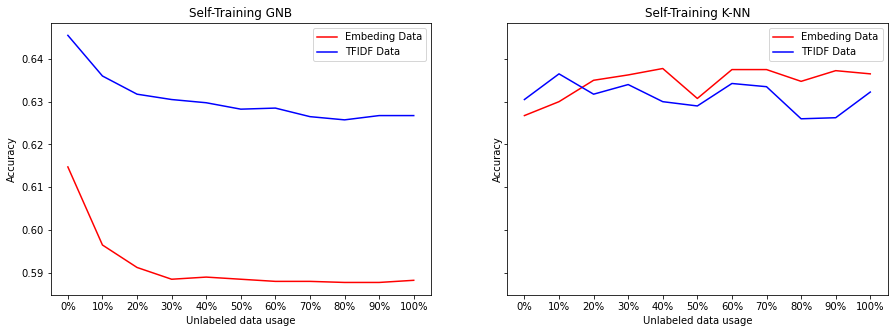

In [40]:
x = np.array([str(i*10) + "%" for i in range(len(embed_record_GNB))])
    
fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

# plot self-training GNB
axs[0].plot(x, np.array(embed_record_GNB), color='r', label='Embeding Data')
axs[0].plot(x, np.array(tfidf_record_GNB), color='b', label='TFIDF Data')
axs[0].set_title("Self-Training GNB")
axs[0].set_xlabel("Unlabeled data usage")
axs[0].set_ylabel("Accuracy")
axs[0].legend()

# plot self-training K-NN
axs[1].plot(x, np.array(embed_record_KNN), color='r', label='Embeding Data')
axs[1].plot(x, np.array(tfidf_record_KNN), color='b', label='TFIDF Data')
axs[1].set_title("Self-Training K-NN")
axs[1].set_xlabel("Unlabeled data usage")
axs[1].set_ylabel("Accuracy")
axs[1].legend()

plt.show()

### Confusion Matrix

In [42]:
print("------------------------Sentence-transformers dataset------------------------")
print("\n")

print("Gaussian Naive Bayes")
print(e_GNB_score[4])
print("\n")

print("Self-Training GNB")
print(e_SelfTrain_GNB_score[4])
print("\n")

print("K-Nearest Neighbors")
print(e_KNN_score[4])
print("\n")

print("Self-Training K-NN")
print(e_SelfTrain_KNN_score[4])
print("\n")

print("------------------------TFIDF dataset------------------------")
print("\n")

print("Gaussian Naive Bayes")
print(t_GNB_score[4])
print("\n")

print("Self-Training GNB")
print(t_SelfTrain_GNB_score[4])
print("\n")

print("K-Nearest Neighbors")
print(t_KNN_score[4])
print("\n")

print("Self-Training K-NN")
print(t_SelfTrain_KNN_score[4])
print("\n")

------------------------Sentence-transformers dataset------------------------


Gaussian Naive Bayes
[[1398  602]
 [ 939 1061]]


Self-Training GNB
[[1496  504]
 [1143  857]]


K-Nearest Neighbors
[[1243  757]
 [ 491 1509]]


Self-Training K-NN
[[1011  989]
 [ 359 1641]]


------------------------TFIDF dataset------------------------


Gaussian Naive Bayes
[[1301  699]
 [ 720 1280]]


Self-Training GNB
[[1322  678]
 [ 815 1185]]


K-Nearest Neighbors
[[1376  624]
 [ 900 1100]]


Self-Training K-NN
[[1290  710]
 [ 748 1252]]


